# 第一步 : 构建交易额模型
 

In [80]:
import datetime as dt
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import solve
from scipy.optimize import curve_fit  #拟合求参数


P1 = 1      #第一次交易额

all_data = pd.read_csv('./all_value.csv',index_col='date')
all_data.index = pd.to_datetime(all_data.index)
all_data

gold_value  pred_value_gold  bitcoin_value  pred_value_bitcoin  \
date                                                                         
2016-09-11     1327.50      1328.499998         621.65          620.941542   
2016-09-12     1327.50      1328.499998         609.67          620.941542   
2016-09-13     1328.50      1328.499998         610.92          620.941542   
2016-09-14     1323.20      1328.499998         608.82          602.572098   
2016-09-15     1320.10      1325.669414         610.38          615.283119   
...                ...              ...            ...                 ...   
2021-09-06     1823.85      1823.850000       51769.06        51477.811350   
2021-09-07     1810.75      1823.850000       52677.40        52881.039630   
2021-09-08     1797.95      1809.755140       46809.17        47269.466480   
2021-09-09     1795.35      1796.969116       46078.38        45831.925410   
2021-09-10     1799.90      1795.150518       46368.69        46316.360400   

            workday  gold_change_days  bit_change_days  g_change  b_change  
date                                                                        
2016-09-11    False               0.0                0  0.000000  0.000000  
2016-09-12     True               0.0                1  0.000000 -0.019650  
2016-09-13     True               1.0                1  0.000753  0.002046  
2016-09-14     True               1.0                1 -0.004005 -0.003449  
2016-09-15     True               2.0                1 -0.006363  0.002556  
...             ...               ...              ...       ...       ...  
2021-09-06     True               1.0                1  0.000000  0.035189  
2021-09-07     True               1.0                2 -0.007235  0.051825  
2021-09-08     True               2.0                1 -0.014405 -0.125365  
2021-09-09     True               3.0                2 -0.015874 -0.143213  
2021-09-10     True               1.0                1  0.002528  0.006261  

[1826 rows x 9 columns]

In [81]:
# 考虑佣金的模型
def model(P1,M05,M01,U1,α):
    if U1 == 4:
        list1 = [ M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α,0,0]
        list2 =[ M05*(1-α)*(1+M01/U1)**2+(1-α)*(1+M01/U1)*M01/U1-α,M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α,0]
        list3 =[ M05*(1-α)*(1+M01/U1)**3+(1-α)*(M01/U1)*(1+(1+M01/U1)**2)-α,M05*(1-α)*(1+M01/U1)**2+(1-α)*(1+M01/U1)*M01/U1-α,M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α]
        list_all = [list1,list2,list3]

        a =np.mat([i[1:] for i in list_all])#系数矩阵
        b =np.mat([i[0]*(-1)*P1 for i in list_all]).T    #常数项列矩阵
        P=solve(a,b)        #方程组的解
        print(P1,P[0],P[1],P[2])
        def y(a,t):
            return a*np.exp(t)

        x = [i for i in range(1,5)]       #x=np.linspace(1,4,4)
        popt, pcov = curve_fit(y,x,[P1,P[0],P[1],P[2]])

        plt.plot(np.linspace(0,4,50),[y(popt[0],t) for t in np.linspace(0,4,50)],'r--')
        plt.plot(x,[y(popt[0],t) for t in x],'b--')
        plt.title('bit -')
        print(popt[0])
        return popt[0]
    else:
        list1 = [ M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α,0]
        list2 =[ M05*(1-α)*(1+M01/U1)**2+(1-α)*(1+M01/U1)*M01/U1-α,M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α]
        list_all = [list1,list2]

        a =np.mat([i[1:] for i in list_all])#系数矩阵
        b =np.mat([i[0]*(-1)*P1 for i in list_all]).T    #常数项列矩阵
        P=solve(a,b)        #方程组的解
        print(P1,P[0],P[1])

        def y(a,t):
            return a*np.exp(t)

        x = [i for i in range(1,4)]      
        popt, pcov = curve_fit(y,x,[P1,P[0],P[1]])

        plt.plot(np.linspace(0,4,50),[y(popt[0],t) for t in np.linspace(0,4,50)],'r--')
        plt.plot(x,[y(popt[0],t) for t in x],'b--')
        plt.title('bit -')
        print(popt[0])
        return popt[0] 

1 [[1.93495745]] [[5.6007355]]
0.4369693761419531
1 [[1.70366002]] [[4.68461849]] [[15.62672291]]
0.9928574620307743
1 [[1.61644955]] [[4.21669551]] [[13.60415393]]
0.8656933551842848
1 [[0.64948417]] [[1.07874645]] [[3.44841749]]
-0.4395971549719433


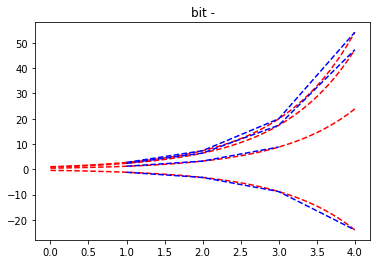

In [86]:
bit_a = 0.001
gold_a = 0.001
A_bit_down = model(P1,0.015516689495233852,-0.125855917,3,bit_a)      #比特币跌时加仓的a
A_bit_up = model(P1,-0.015195236993925254,0.177859096,4,bit_a)     #bitcoin涨时减仓的a
A_gold_down = model(P1,0.004628232216520685,-0.037786983,4,gold_a)
A_gold_up = model(P1,-0.0043653219295970245,0.035561898,4,gold_a)

### 

# 构建交易策略并得出结果

In [87]:
#黄金的交易额
def gold_trade(change):  #w为累计涨跌幅
    if(change < 0):     #累积跌，则加仓
        return abs(A_gold_down*np.exp(4*change/-0.037786983))
    elif(change > 0):   #累积涨，则减仓
        return abs(A_gold_up*np.exp(4*change/0.035561898))
    else:
        return 0

#比特币
def bit_trade(change):  #w为累计涨跌幅
    if(change < 0):   #累积跌，则加仓
        return abs(A_bit_down*np.exp(3*change/-0.125855917))
    elif(change > 0):   #累积涨，则减仓
        return abs(A_bit_up*np.exp(4*change/0.177859096))
    else:
        return 0

date
2016-09-11     1000.000000
2016-09-12      999.986039
2016-09-13      999.973733
2016-09-14      999.951016
2016-09-15      999.922838
                  ...     
2021-09-06    39365.657066
2021-09-07    40010.325930
2021-09-08    35794.828455
2021-09-09    35268.914675
2021-09-10    35479.603971
Name: money, Length: 1826, dtype: float64


<AxesSubplot:xlabel='date'>

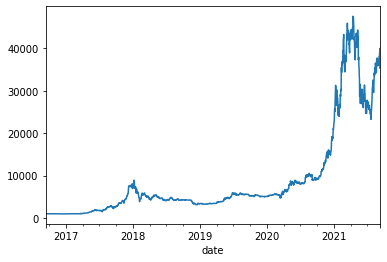

In [88]:
date_asset = {pd.to_datetime('2016-09-11'):[1000,0,0]}   #字典存放所有天的资产组合情况[c,g,b]，第一天1000现金
# 存放的是黄金和比特币的份额

# 策略与预测分离
def strategy(date,asset_date,b_price,g_price,bchange,gchange,workday):     #price价格为今天的，pred预测为明天的，gold可选，若不传入则为0
    asset_tomor = asset_date      #asset_date是[]，现在的资产
    if workday == 'False':          #今天只能交易比特币
        if bchange > 0:   #减仓
            bmin = min(asset_date[2]*b_price,bit_trade(bchange))        #卖出的金额
            asset_tomor[0] = asset_date[0] + bmin*0.98
            asset_tomor[2] = asset_date[2] - bmin/b_price        #bit卖出的份额
        elif bchange < 0:  #加仓
            bmin_add = min(asset_date[0],bit_trade(bchange))            #买入的金额
            asset_tomor[0] = asset_date[0] - bmin_add
            asset_tomor[2] = asset_date[2] + bmin_add*0.98/b_price         #买入的份额
        else:       #平
            pass
    else:
        if gchange > 0:       #黄金减仓
            gmin = min(asset_date[1]*g_price,gold_trade(gchange))        #卖出的金额
            asset_tomor[0] = asset_date[0] + 0.99*gmin
            asset_tomor[1] = asset_date[1] - gmin/g_price
            if bchange > 0:   #减仓
                bmin = min(asset_date[2]*b_price,bit_trade(bchange))        #卖出的金额
                asset_tomor[0] = asset_date[0] + bmin*0.98
                asset_tomor[2] = asset_date[2] - bmin/b_price        #bit卖出的份额
            elif bchange < 0:  #加仓
                bmin_add = min(asset_date[0],bit_trade(bchange))            #买入的金额
                asset_tomor[0] = asset_date[0] - bmin_add
                asset_tomor[2] = asset_date[2] + bmin_add*0.98/b_price         #买入的份额
            else:
                pass
        elif gchange < 0 :  #黄金加仓
            gmin_add = min(asset_date[0],gold_trade(gchange))      #买多少
            asset_tomor[0] = asset_date[0] - gmin_add
            asset_tomor[1] = asset_date[1] + gmin_add*0.99/g_price
            if bchange > 0:   #减仓
                bmin = min(asset_date[2]*b_price,bit_trade(bchange))        #卖出的金额
                asset_tomor[0] = asset_date[0] + bmin*0.98
                asset_tomor[2] = asset_date[2] - bmin/b_price        #bit卖出的份额
            elif bchange < 0:  #加仓
                bmin_add = min(asset_date[0],bit_trade(bchange))            #买入的金额
                asset_tomor[0] = asset_date[0] - bmin_add
                asset_tomor[2] = asset_date[2] + bmin_add*0.98/b_price         #买入的份额
            else:
                pass
        else:        #黄金不变
            if bchange > 0:   #减仓
                bmin = min(asset_date[2]*b_price,bit_trade(bchange))        #卖出的金额
                asset_tomor[0] = asset_date[0] + bmin*0.98
                asset_tomor[2] = asset_date[2] - bmin/b_price        #bit卖出的份额
            elif bchange < 0:  #加仓
                bmin_add = min(asset_date[0],bit_trade(bchange))            #买入的金额
                asset_tomor[0] = asset_date[0] - bmin_add
                asset_tomor[2] = asset_date[2] + bmin_add*0.98/b_price         #买入的份额
            else:
                pass
    return asset_tomor


for i in all_data.index:
    asset_tomor = strategy(i,date_asset[i],all_data.bitcoin_value[i],all_data.gold_value[i],all_data.b_change[i],all_data.g_change[i],all_data.workday[i])
    date_asset[i+dt.timedelta(1)] = asset_tomor.copy()       #用copy不然会 传入地址

# 将每天的资产放入总数据中
asset_df = pd.DataFrame.from_dict(date_asset,orient='index',columns=['cash','gold','bitcoin'])
res = all_data.join(asset_df)
res['gold_'] = res.gold_value * res.gold
res['bitcoin_'] = res.bitcoin_value * res.bitcoin
res['money'] = res.cash + res.gold_ + res.bitcoin_
print(res.money)
res.money.plot()

In [91]:
# res.to_csv('./考虑佣金result.csv',index='True')
res

gold_value  pred_value_gold  bitcoin_value  pred_value_bitcoin  \
date                                                                         
2016-09-11     1327.50      1328.499998         621.65          620.941542   
2016-09-12     1327.50      1328.499998         609.67          620.941542   
2016-09-13     1328.50      1328.499998         610.92          620.941542   
2016-09-14     1323.20      1328.499998         608.82          602.572098   
2016-09-15     1320.10      1325.669414         610.38          615.283119   
...                ...              ...            ...                 ...   
2021-09-06     1823.85      1823.850000       51769.06        51477.811350   
2021-09-07     1810.75      1823.850000       52677.40        52881.039630   
2021-09-08     1797.95      1809.755140       46809.17        47269.466480   
2021-09-09     1795.35      1796.969116       46078.38        45831.925410   
2021-09-10     1799.90      1795.150518       46368.69        46316.360400   

            workday  gold_change_days  bit_change_days  g_change  b_change  \
date                                                                         
2016-09-11    False               0.0                0  0.000000  0.000000   
2016-09-12     True               0.0                1  0.000000 -0.019650   
2016-09-13     True               1.0                1  0.000753  0.002046   
2016-09-14     True               1.0                1 -0.004005 -0.003449   
2016-09-15     True               2.0                1 -0.006363  0.002556   
...             ...               ...              ...       ...       ...   
2021-09-06     True               1.0                1  0.000000  0.035189   
2021-09-07     True               1.0                2 -0.007235  0.051825   
2021-09-08     True               2.0                1 -0.014405 -0.125365   
2021-09-09     True               3.0                2 -0.015874 -0.143213   
2021-09-10     True               1.0                1  0.002528  0.006261   

                   cash      gold   bitcoin       gold_      bitcoin_  \
date                                                                    
2016-09-11  1000.000000  0.000000  0.000000    0.000000      0.000000   
2016-09-12   999.301975  0.000000  0.001122    0.000000      0.684065   
2016-09-13   999.973733  0.000000  0.000000    0.000000      0.000000   
2016-09-14   998.176482  0.000990  0.000764    1.309607      0.464927   
2016-09-15   996.935437  0.002263  0.000000    2.987401      0.000000   
...                 ...       ...       ...         ...           ...   
2021-09-06  1292.760535  0.516081  0.717255  941.254653  37131.641878   
2021-09-07  1294.019660  0.517099  0.717195  936.337280  37779.968990   
2021-09-08  1281.367441  0.519289  0.717377  933.656202  33579.804812   
2021-09-09  1263.446164  0.521852  0.717659  936.906382  33068.562130   
2021-09-10  1265.144615  0.521527  0.717634  938.696633  33275.762723   

                   money  
date                      
2016-09-11   1000.000000  
2016-09-12    999.986039  
2016-09-13    999.973733  
2016-09-14    999.951016  
2016-09-15    999.922838  
...                  ...  
2021-09-06  39365.657066  
2021-09-07  40010.325930  
2021-09-08  35794.828455  
2021-09-09  35268.914675  
2021-09-10  35479.603971  

[1826 rows x 15 columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


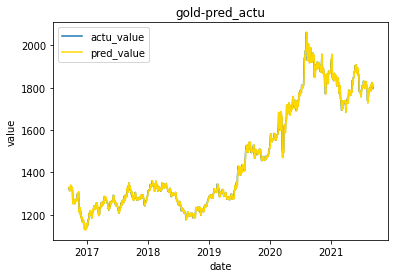

In [77]:
plt.plot(res.gold_value,label='actu_value')       #持有money
plt.plot(res.pred_value_gold,label='pred_value',color='gold')       #持有money
plt.xlabel("date") #x轴命名表示
plt.ylabel("value") #y轴命名表示
plt.title("gold-pred_actu") 
plt.legend()#增加图例
plt.savefig('./gold.eps',format='eps',dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


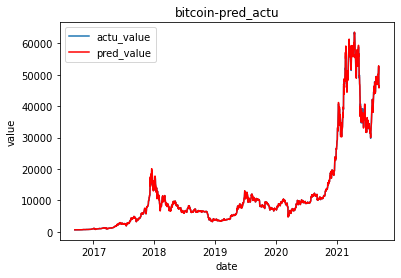

In [78]:
plt.plot(res.bitcoin_value,label='actu_value')       #持有money
plt.plot(res.pred_value_bitcoin,label='pred_value',color='r')       #持有money
plt.xlabel("date") #x轴命名表示
plt.ylabel("value") #y轴命名表示
plt.title("bitcoin-pred_actu") 
plt.legend()#增加图例
plt.savefig('./bitcoin.eps',format='eps',dpi=150)

# 持仓结果与价格对比

## 所持资产的价值总和变动

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


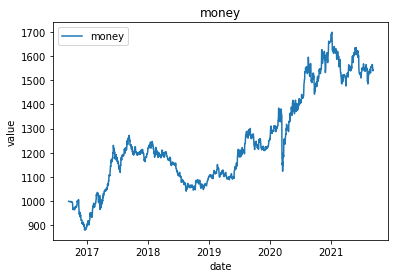

In [79]:
# 持有money变动情况
plt.plot(res.money,label='money')       #持有money
plt.xlabel("date") #x轴命名表示
plt.ylabel("value") #y轴命名表示
plt.title("money") 
plt.legend()#增加图例
plt.savefig('./money.eps',format='eps',dpi=150)

## 所持资产中现金 -黄金 -比特币 各自价值变动

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


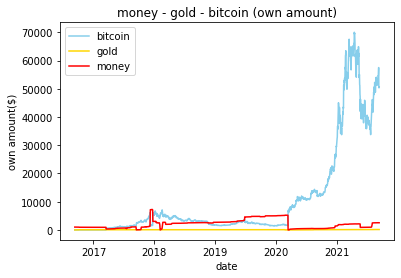

In [60]:
# 持仓中现金-黄金-比特币 金额 对比图
plt.plot(res.bitcoin_ ,color="skyblue",label="bitcoin")    #比特币价格
plt.plot(res.gold_,color='gold',label="gold")  #黄金价格
plt.plot(res.cash, color='r',label='money')       #持有money
plt.xlabel("date") #x轴命名表示
plt.ylabel("own amount($)") #y轴命名表示
plt.title("money - gold - bitcoin (own amount)") 
plt.legend()#增加图例
plt.savefig('./money-gold-bitcoin(own amount).eps',format='eps',dpi=150)

## 黄金价格 与 所持黄金的价值 变动趋势

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


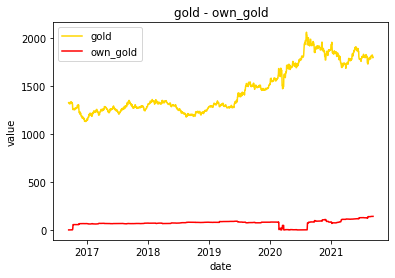

In [61]:
# 黄金价格 / 所持黄金的价值 对比图
plt.plot(res.gold_value,color='gold',label="gold")  #黄金价格
plt.plot(res.gold_, color='r',label='own_gold')       #持有money
plt.xlabel("date") #x轴命名表示
plt.ylabel("value") #y轴命名表示
plt.title("gold - own_gold") 
plt.legend()#增加图例
plt.savefig('./gold-own_gold.eps',format='eps',dpi=150)

## 比特币价格 与 所持比特币的价值 变动

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


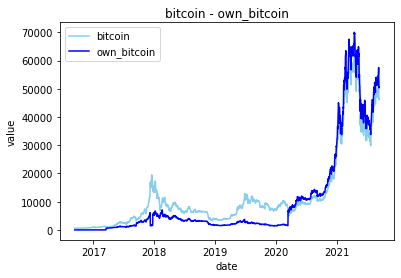

In [62]:
# 比特币价格 / 所持比特币的价值 对比图
plt.figure()
plt.plot(res.bitcoin_value,color='skyblue',label="bitcoin")  #黄金价格
plt.plot(res.bitcoin_, color='b',label='own_bitcoin')       #持有money
plt.xlabel("date") #x轴命名表示
plt.ylabel("value") #y轴命名表示
plt.title("bitcoin - own_bitcoin") 
plt.legend()#增加图例
plt.savefig('./bitcoin-own_bitcoin.eps',format='eps',dpi=150)

# 构建模型时考虑佣金

In [92]:
import datetime as dt
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import solve
from scipy.optimize import curve_fit  #拟合求参数

def get_plot(P1,gold_a, bit_a):
    # 数据输入
    # P1 = 3      #第一次交易额

    all_data = pd.read_csv('./all_value.csv',index_col='date')
    all_data.index = pd.to_datetime(all_data.index)

    # 模型
    def model(P1,M05,M01,U1,α):
        if U1 == 4:
            list1 = [ M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α,0,0]
            list2 =[ M05*(1-α)*(1+M01/U1)**2+(1-α)*(1+M01/U1)*M01/U1-α,M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α,0]
            list3 =[ M05*(1-α)*(1+M01/U1)**3+(1-α)*(M01/U1)*(1+(1+M01/U1)**2)-α,M05*(1-α)*(1+M01/U1)**2+(1-α)*(1+M01/U1)*M01/U1-α,M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α]
            list_all = [list1,list2,list3]
            # list1 = [ M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α,0,0]
            # list2 =[ M05*(1-α)*(1+M01/U1)**2+(1-α)*(1+M01/U1)*M01/U1-α,M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α,0]
            # list3 =[ M05*(1-α)*(1+M01/U1)**3+(1-α)*(M01/U1)*(1+M01/U1)**2+(1-α)*(M01/U1)*(1+M01/U1)-α,M05*(1-α)*(1+M01/U1)**2+(1-α)*(1+M01/U1)*M01/U1-α,M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α]
            # list_all = [list1,list2,list3]
            a =np.mat([i[1:] for i in list_all])#系数矩阵
            b =np.mat([i[0]*(-1)*P1 for i in list_all]).T    #常数项列矩阵
            P=solve(a,b)        #方程组的解
            def y(a,t):
                return a*np.exp(t)

            x = [i for i in range(1,5)]       #x=np.linspace(1,4,4)
            popt, pcov = curve_fit(y,x,[P1,P[0],P[1],P[2]])
            return popt[0]
        else:
            list1 = [ M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α,0]
            list2 =[ M05*(1-α)*(1+M01/U1)**2+(1-α)*(1+M01/U1)*M01/U1-α,M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α]
            # list1 = [ M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α,0]
            # list2 =[ M05*(1-α)*(1+M01/U1)**2+(1-α)*(1+M01/U1)*M01/U1-α,M05*(1+M01/U1)*(1-α)+(1-α)*M01/U1-α ,M05*(1-α)-α]
            list_all = [list1,list2]

            a =np.mat([i[1:] for i in list_all])#系数矩阵
            b =np.mat([i[0]*(-1)*P1 for i in list_all]).T    #常数项列矩阵
            P=solve(a,b)        #方程组的解
            # print(P1,P[0],P[1])

            def y(a,t):
                return a*np.exp(t)

            x = [i for i in range(1,4)]      
            popt, pcov = curve_fit(y,x,[P1,P[0],P[1]])
            return popt[0] 

    A_bit_down = model(P1,0.015516689495233852,-0.125855917,3,bit_a)      #比特币跌时加仓的a
    A_bit_up = model(P1,-0.015195236993925254,0.177859096,4,bit_a)     #bitcoin涨时减仓的a
    A_gold_down = model(P1,0.004628232216520685,-0.037786983,4,gold_a)
    A_gold_up = model(P1,-0.0043653219295970245,0.035561898,4,gold_a)

    #黄金的交易额
    def gold_trade(change):  #w为累计涨跌幅
        if(change < 0):     #累积跌，则加仓
            return abs(A_gold_down*np.exp(4*change/-0.037786983))
        elif(change > 0):   #累积涨，则减仓
            return abs(A_gold_up*np.exp(4*change/0.035561898))
        else:
            return 0

    #比特币交易额
    def bit_trade(change):  #w为累计涨跌幅
        if(change < 0):   #累积跌，则加仓
            return abs(A_bit_down*np.exp(3*change/-0.125855917))
        elif(change > 0):   #累积涨，则减仓
            return abs(A_bit_up*np.exp(4*change/0.177859096))
        else:
            return 0


    date_asset = {pd.to_datetime('2016-09-11'):[1000,0,0]}   #字典存放所有天的资产组合情况[c,g,b]，第一天1000现金
    # 存放的是黄金和比特币的份额

    # 交易策略
    def strategy(date,asset_date,b_price,g_price,bchange,gchange,workday):     #price价格为今天的，pred预测为明天的，gold可选，若不传入则为0
        asset_tomor = asset_date      #asset_date是[]，现在的资产
        if workday == 'False':          #今天只能交易比特币
            if bchange > 0:   #减仓
                bmin = min(asset_date[2]*b_price,bit_trade(bchange))        #卖出的金额
                asset_tomor[0] = asset_date[0] + bmin*0.98
                asset_tomor[2] = asset_date[2] - bmin/b_price        #bit卖出的份额
            elif bchange < 0:  #加仓
                bmin_add = min(asset_date[0],bit_trade(bchange))            #买入的金额
                asset_tomor[0] = asset_date[0] - bmin_add
                asset_tomor[2] = asset_date[2] + bmin_add*0.98/b_price         #买入的份额
            else:       #平
                pass
        else:
            if gchange > 0:       #黄金减仓
                gmin = min(asset_date[1]*g_price,gold_trade(gchange))        #卖出的金额
                asset_tomor[0] = asset_date[0] + 0.99*gmin
                asset_tomor[1] = asset_date[1] - gmin/g_price
                if bchange > 0:   #减仓
                    bmin = min(asset_date[2]*b_price,bit_trade(bchange))        #卖出的金额
                    asset_tomor[0] = asset_date[0] + bmin*0.98
                    asset_tomor[2] = asset_date[2] - bmin/b_price        #bit卖出的份额
                elif bchange < 0:  #加仓
                    bmin_add = min(asset_date[0],bit_trade(bchange))            #买入的金额
                    asset_tomor[0] = asset_date[0] - bmin_add
                    asset_tomor[2] = asset_date[2] + bmin_add*0.98/b_price         #买入的份额
                else:
                    pass
            elif gchange < 0 :  #黄金加仓
                gmin_add = min(asset_date[0],gold_trade(gchange))      #买多少
                asset_tomor[0] = asset_date[0] - gmin_add
                asset_tomor[1] = asset_date[1] + gmin_add*0.99/g_price
                if bchange > 0:   #减仓
                    bmin = min(asset_date[2]*b_price,bit_trade(bchange))        #卖出的金额
                    asset_tomor[0] = asset_date[0] + bmin*0.98
                    asset_tomor[2] = asset_date[2] - bmin/b_price        #bit卖出的份额
                elif bchange < 0:  #加仓
                    bmin_add = min(asset_date[0],bit_trade(bchange))            #买入的金额
                    asset_tomor[0] = asset_date[0] - bmin_add
                    asset_tomor[2] = asset_date[2] + bmin_add*0.98/b_price         #买入的份额
                else:
                    pass
            else:        #黄金不变
                if bchange > 0:   #减仓
                    bmin = min(asset_date[2]*b_price,bit_trade(bchange))        #卖出的金额
                    asset_tomor[0] = asset_date[0] + bmin*0.98
                    asset_tomor[2] = asset_date[2] - bmin/b_price        #bit卖出的份额
                elif bchange < 0:  #加仓
                    bmin_add = min(asset_date[0],bit_trade(bchange))            #买入的金额
                    asset_tomor[0] = asset_date[0] - bmin_add
                    asset_tomor[2] = asset_date[2] + bmin_add*0.98/b_price         #买入的份额
                else:
                    pass
        return asset_tomor


    for i in all_data.index:
        asset_tomor = strategy(i,date_asset[i],all_data.bitcoin_value[i],all_data.gold_value[i],all_data.b_change[i],all_data.g_change[i],all_data.workday[i])
        date_asset[i+dt.timedelta(1)] = asset_tomor.copy()
    
    # 将每天的资产放入总数据中
    asset_df = pd.DataFrame.from_dict(date_asset,orient='index',columns=['cash','gold','bitcoin'])
    res = all_data.join(asset_df)
    res['money'] = res.cash + res.gold*res.gold_value + res.bitcoin*res.bitcoin_value
    # res.money.plot()
    return res.money[-1]         #返回最终持有资产的总额

In [64]:

print(get_plot(1,0,0))        #不设置佣金
print(get_plot(1,0.01,0.02))       #设置佣金为黄金0.01，比特币0.02

53323.958548203336
1542.7784634375894


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1] [54180.09751691231, 1139.5151596672588, 1001.5321459663922, 6467.956399854531, 7736.887948471582, 7641.4460306038145, 8409.870696778464, 9469.539683468935, 10394.419693563454, 9810.475612031258, 10442.44347048581]


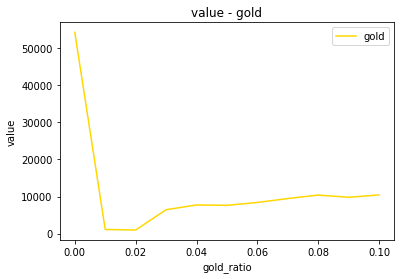

In [93]:
x = []
y = []
for i in np.linspace(0,0.1,11):
    x.append(i)
    y.append(get_plot(1,i,0.001))
print(x,y)
plt.figure()
plt.plot(x,y,color='gold',label="gold")  #黄金价格
plt.xlabel("gold_ratio") #x轴命名表示
plt.ylabel("value") #y轴命名表示
plt.title("value - gold") 
plt.legend()#增加图例
plt.savefig('./value_goldratio.eps',format='eps',dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


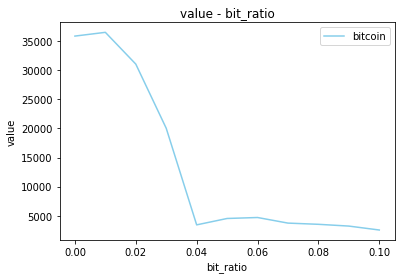

In [94]:
x = []
y = []
for i in np.linspace(0,0.1,11):
    x.append(i)
    y.append(get_plot(1,0.001,i))
# 比特币价格 / 所持比特币的价值 对比图
plt.figure()
plt.plot(x,y,color='skyblue',label="bitcoin")  #黄金价格
plt.xlabel("bit_ratio") #x轴命名表示
plt.ylabel("value") #y轴命名表示
plt.title("value - bit_ratio") 
plt.legend()#增加图例
plt.savefig('./value_bitratio.eps',format='eps',dpi=150)